# German Traffic Sign Classifier

## Step 0: Load The Data

In [23]:
# Load pickled data
import pickle
import csv

training_file = 'data/signs/train.p'
validation_file= 'data/signs/valid.p'
testing_file = 'data/signs/test.p'
names_file = 'data/signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [24]:
# Create a mapping of ID to name from CSV file.
id2name = dict()
with open(names_file, mode='r') as f:
    csvreader = csv.reader(f, delimiter=',')
    for row in csvreader:
        try:
            ID = int(row[0])
        except:
            # Skip lines that do not begin with a number
            continue
        id2name[ID] = row[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [25]:
# Provide a basic summary of the raw data
n_train = train['features'].shape[0]
n_validation = valid['features'].shape[0]
n_test = test['features'].shape[0]

image_shape = train['features'].shape[1:]
n_classes = len(id2name)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

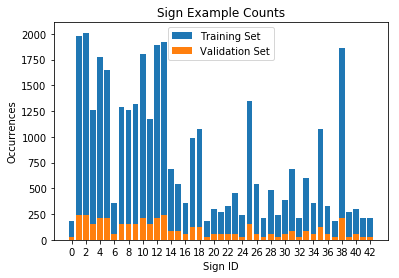

In [26]:
# Provide further statistics on the dataset

import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
%matplotlib inline

# Plot the number of examples for each sign class
def plot_record_count_in(y_set, title='Sign Example Counts'):
    counts = [0] * n_classes
    for y in y_set:
        counts[y] += 1
    plt.bar(np.arange(n_classes), counts)
    plt.xticks(range(0, n_classes, 2))
    plt.title(title)
    plt.xlabel('Sign ID')
    plt.ylabel('Occurrences')

plot_record_count_in(y_train)
plot_record_count_in(y_valid)
plt.legend(['Training Set','Validation Set'])

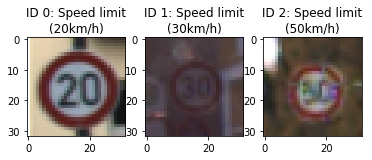

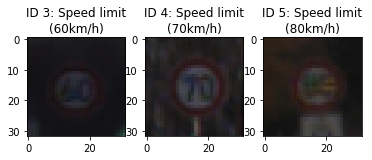

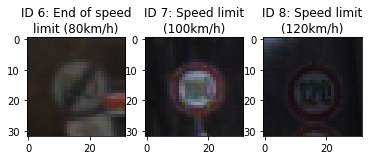

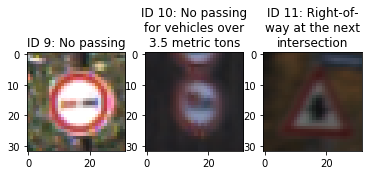

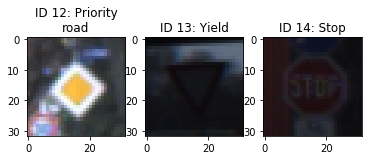

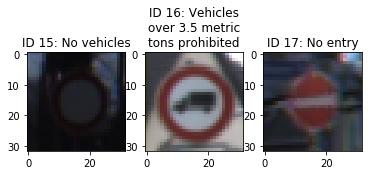

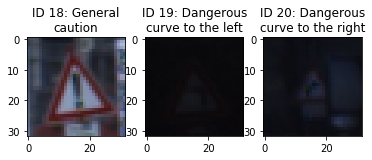

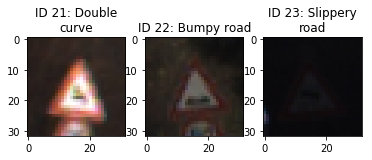

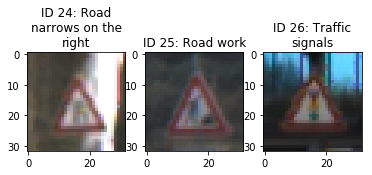

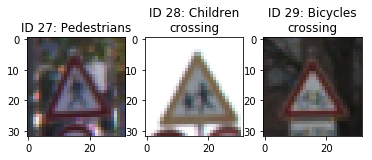

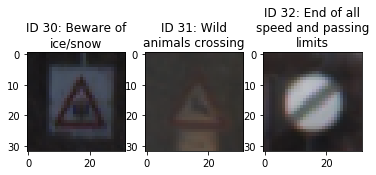

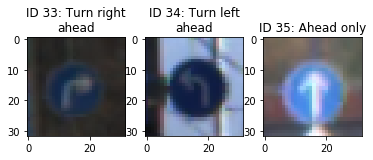

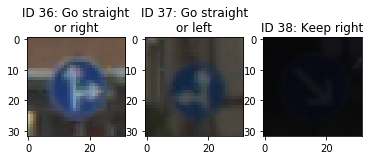

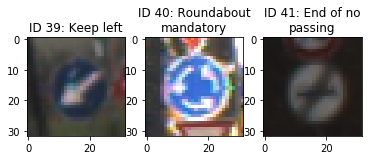

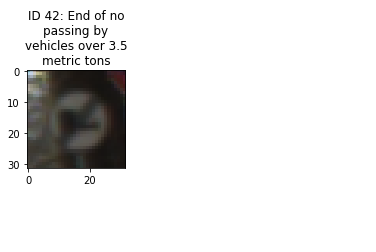

In [27]:
# Plot an example of each raw image from the training set
def display_records(x, y):
    n_col = 3
    title_width = 18
    for row in range(n_classes//n_col+1):
        fig, axes = plt.subplots(1, n_col)
        for i, plot in enumerate(axes.flatten()):
            i += row * n_col
            if i in id2name:
                plot.set_title("\n".join(wrap(
                    'ID {}: '.format(i) + id2name[i], title_width)))
                plot.imshow(x[np.where(y==i)][0])
            else:
                plot.axis('off')

display_records(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Train data size, before crop  (34799, 32, 32, 3)
Train data size, after crop (34799, 26, 26, 3)
Updated image shape: (26, 26, 3)


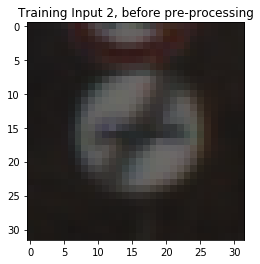

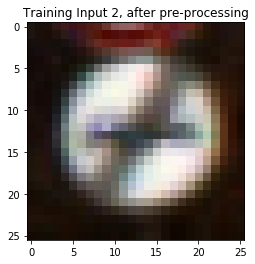

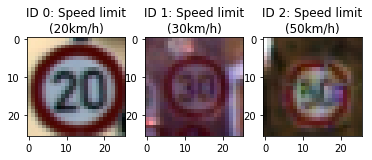

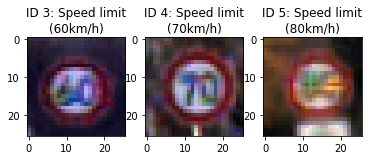

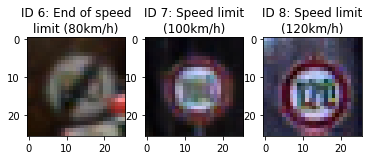

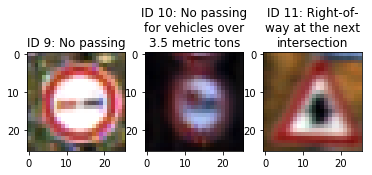

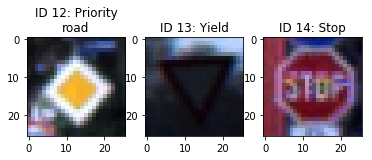

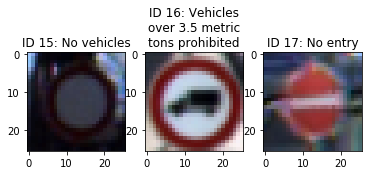

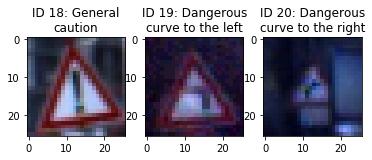

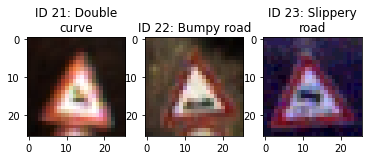

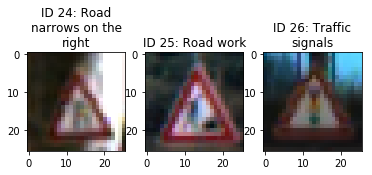

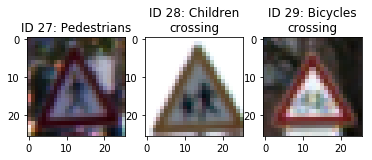

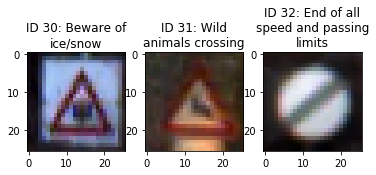

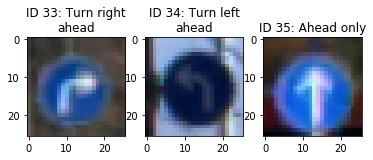

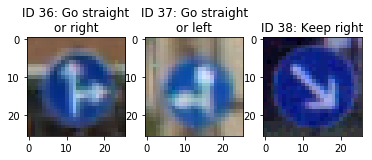

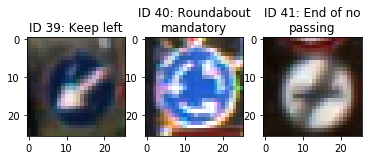

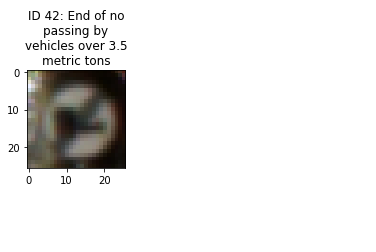

In [28]:
### Preprocess the data.

import cv2

# Modification options
example_record = 2 # training example to show before/after processing image
HSV = False # transform input from RGB to HSV?
do_crop = True # crop images?
crop = 3 # pixels to crop out from each side of the image

# Show raw image example
plt.imshow(X_train[example_record])
plt.title('Training Input {}, before pre-processing'.format(example_record))
imbefore = X_train[example_record]

# Apply crop
if do_crop:
    print('Train data size, before crop  {}'.format(X_train.shape))
    X_train = X_train[:,crop:-crop,crop:-crop,:]
    X_valid = X_valid[:,crop:-crop,crop:-crop,:]
    X_test = X_test[:,crop:-crop,crop:-crop,:]
    print('Train data size, after crop {}'.format(X_train.shape))
else:
    print('No crop applied')  
    
# Modify each image
for i, dataset in enumerate([X_train, X_valid, X_test]):
    for j, img in enumerate(dataset):
        cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
        if HSV:
            dataset[j] = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Show after pre-processing example
print('Updated image shape: {}'.format(X_valid[example_record].shape))
plt.figure()
plt.imshow(X_train[example_record])
plt.title('Training Input {}, after pre-processing'.format(example_record))
imafter = X_train[example_record]

# Plot an example of each image from the training set
display_records(X_train, y_train)

### Model Architecture

In [29]:
import tensorflow as tf

# Hyperparameters
weight_stddev = 0.01
conv_kernel = 3
keep_prob = 0.5
keep_prob_tf = tf.placeholder(tf.float32)

# Settings
input_depth = X_train.shape[3]
print('input_depth = {}'.format(input_depth))

# Model
model_size = 0 # number of parameters in the model (to be calculated)
def predict(x):
    '''Given an image, returns the logits of the NN'''
    # Conv Layer 1
    conv1 = conv(x, maps_out=32, pool=False)
    print('Conv 1 output size: {}'.format(conv1.shape))
    
    # Conv Layer 2
    conv2 = conv(conv1, maps_out=48, pool=True)
    print('Conv 2 output size: {}'.format(conv2.shape))
    
    # Conv Layer 3
    conv3 = conv(conv2, maps_out=144, pool=True)
    print('Conv 3 output size: {}'.format(conv3.shape))
    
    # Conv Layer 4
    conv_out = conv(conv3, maps_out=432, pool=True)
    print('Conv 4 output size: {}'.format(conv_out.shape))
    
    # Setup fully connected input
    fc0 = tf.contrib.layers.flatten(conv_out)
    fc0_features = int(fc0.shape[-1])
    print('Fully connected input size: {}'.format(fc0.shape))
    
    # Fully Conected Layer 1
    fc1 = fc(fc0, features_out=512)
    print('Fully connected 1 output size: {}'.format(fc1.shape))
    
    # Fully Conected Layer 2
    fc2 = fc(fc1, features_out=256)
    print('Fully connected 2 output size: {}'.format(fc2.shape))
    
    # Fully Conected Layer (Output)
    fcout = fc(fc2, features_out=n_classes, relu=False, dropout=False)
    print('Fully connected 3 output size: {}'.format(fcout.shape))
    print('Model size: {:,} parameters'.format(model_size))
    return fcout

def fc(x, features_out, relu=True, dropout=True):
    '''Returns a tensor for a fully connected layer supporting dropout
       `features_out` -- number of nodes in the layer
       `relu` -- weather to apply a relu
    '''
    # Calculate output
    W = tf.Variable(tf.truncated_normal([int(x.shape[-1]), features_out], stddev = weight_stddev))
    b = tf.Variable(tf.zeros(features_out))
    fc = tf.matmul(x, W) + b
    
    # Apply relu and dropout
    if relu:
        fc = tf.nn.relu(fc)
    if dropout:
        fc = tf.nn.dropout(fc, keep_prob_tf)
    
    # Increment model size
    global model_size
    model_size += int(x.shape[-1]) * features_out + features_out
    
    return fc

def conv(x, maps_out, pool=True, relu=True):
    '''Returns a tensor for a convolutional layer supporting dropout
       `features_out` -- number of nodes in the layer
       `pool` -- whether to apply max pooling with stide of 2
       `relu` -- whether to apply a relu
    '''
    # Calculate output
    W = tf.Variable(tf.truncated_normal([conv_kernel, conv_kernel, int(x.shape[-1]), maps_out], stddev = weight_stddev))
    b = tf.Variable(tf.zeros(maps_out))
    conv = tf.nn.conv2d(x, W, [1,1,1,1], 'VALID') + b
    
    # Apply relu, pooling, dropout
    if relu:
        conv = tf.nn.relu(conv)
    if pool:
        conv = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    conv = tf.nn.dropout(conv, keep_prob_tf)
    
    # Increment model size
    global model_size
    model_size += conv_kernel**2 + int(x.shape[-1]) * maps_out + maps_out
    
    return conv

input_depth = 3


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [30]:
# Set up features and labels
x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Set training hyperparameters
EPOCHS = 30
BATCH_SIZE = 512
RATE = 0.001

# Print architecture setup
model_size = 0
print('======================================')
print('~~ Architecture ~~')
print('HSV = {}'.format(HSV))
print('do_crop = {}'.format(do_crop))
if do_crop:
    print('crop = {}'.format(crop))

print('\nweight_stddev = {}'.format(weight_stddev))
print('conv_kernel = {}'.format(conv_kernel))
print('keep_prob = {}\n'.format(keep_prob))

# Training pipeline
logits = predict(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

# Print (more) architecture setup
print('\n~~ Training ~~')
print('EPOCHS = {}'.format(EPOCHS))
print('BATCH_SIZE = {}'.format(BATCH_SIZE))
print('RATE = {}'.format(RATE))
print('======================================')

# Evaluation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_tf: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

~~ Architecture ~~
HSV = False
do_crop = True
crop = 3

weight_stddev = 0.01
conv_kernel = 3
keep_prob = 0.5

Conv 1 output size: (?, 24, 24, 32)
Conv 2 output size: (?, 11, 11, 48)
Conv 3 output size: (?, 4, 4, 144)
Conv 4 output size: (?, 1, 1, 432)
Fully connected input size: (?, 432)
Fully connected 1 output size: (?, 512)
Fully connected 2 output size: (?, 256)
Fully connected 3 output size: (?, 43)
Model size: 435,519 parameters

~~ Training ~~
EPOCHS = 30
BATCH_SIZE = 512
RATE = 0.001


In [31]:
# Run training
from sklearn.utils import shuffle
accuracies = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("\nTraining...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_tf: keep_prob})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        accuracies.append(1.0 - validation_accuracy)
        
    saver.save(sess, './data/best_model.ckpt')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.054
EPOCH 2 ...
Validation Accuracy = 0.102
EPOCH 3 ...
Validation Accuracy = 0.255
EPOCH 4 ...
Validation Accuracy = 0.342
EPOCH 5 ...
Validation Accuracy = 0.486
EPOCH 6 ...
Validation Accuracy = 0.797
EPOCH 7 ...
Validation Accuracy = 0.872
EPOCH 8 ...
Validation Accuracy = 0.903
EPOCH 9 ...
Validation Accuracy = 0.952
EPOCH 10 ...
Validation Accuracy = 0.944
EPOCH 11 ...
Validation Accuracy = 0.973
EPOCH 12 ...
Validation Accuracy = 0.966
EPOCH 13 ...
Validation Accuracy = 0.978
EPOCH 14 ...
Validation Accuracy = 0.972
EPOCH 15 ...
Validation Accuracy = 0.974
EPOCH 16 ...
Validation Accuracy = 0.985
EPOCH 17 ...
Validation Accuracy = 0.977
EPOCH 18 ...
Validation Accuracy = 0.984
EPOCH 19 ...
Validation Accuracy = 0.987
EPOCH 20 ...
Validation Accuracy = 0.989
EPOCH 21 ...
Validation Accuracy = 0.981
EPOCH 22 ...
Validation Accuracy = 0.983
EPOCH 23 ...
Validation Accuracy = 0.981
EPOCH 24 ...
Validation Accuracy = 0.977
EPOCH 25 ..

~~Results~~
Best Accuracy: 	98.91% @ epoch 19
Compared to human: 0.10% less



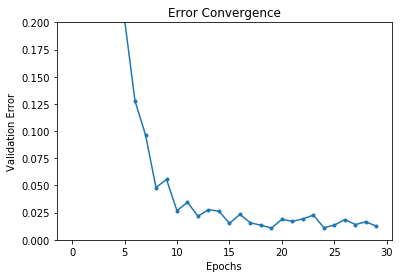

In [35]:
# Post-optimization Stats
human_acc = .9881
print('~~Results~~')
print('Best Accuracy: \t{:.2f}% @ epoch {}'.format((1.0-min(accuracies))*100, np.argmin(accuracies)))
print('Compared to human: {:.2f}% less\n'.format((-human_acc + (1.0 - min(accuracies)))*100))

plt.plot(range(len(accuracies)),accuracies,'.-')
plt.ylim([0.0,0.2])
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('Error Convergence')

In [56]:
# Run Test set
print('Testing best_model.ckpt against test set.\n')
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './data/best_model.ckpt')
    print("\nRunning Test set...")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}%".format(test_accuracy*100))
    print('Compared to human: {:.2f}% less\n'.format((human_acc - test_accuracy)*100))

Testing best_model.ckpt against test set.

INFO:tensorflow:Restoring parameters from ./data/best_model.ckpt

Running Test set...
Test Accuracy = 97.759%
Compared to human: 1.05% less



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

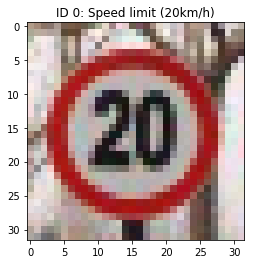

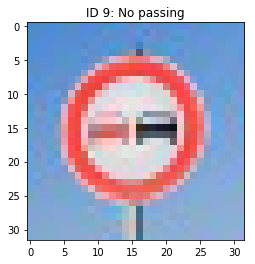

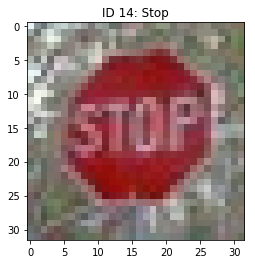

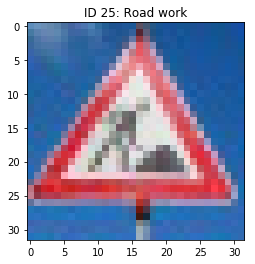

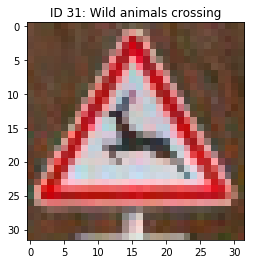

In [49]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
%matplotlib inline

id0_img  = np.expand_dims(plt.imread('./data/test_signs/id0.jpg'),  axis = 0)
id9_img  = np.expand_dims(plt.imread('./data/test_signs/id9.jpg'),  axis = 0)
id14_img = np.expand_dims(plt.imread('./data/test_signs/id14.jpg'), axis = 0)
id25_img = np.expand_dims(plt.imread('./data/test_signs/id25.jpg'), axis = 0)
id31_img = np.expand_dims(plt.imread('./data/test_signs/id31.jpg'), axis = 0)

X_newtest = np.concatenate((id0_img, id9_img, id14_img, id25_img, id31_img), axis=0)
y_newtest = [0, 9, 14, 25, 31]

def show_all(x, y):
    title_width = 30
    for j, img in enumerate(x):
        plt.figure()
        plt.imshow(img)
        i = y[j]
        plt.title("\n".join(wrap('ID {}: '.format(i) + id2name[i], title_width)))
        
show_all(X_newtest, y_newtest)

### Preprocess

In [50]:
# Apply crop
if do_crop:
    print('data size, before crop  {}'.format(X_newtest.shape))
    X_newtest = X_newtest[:,crop:-crop,crop:-crop,:]
    print('data size, after crop {}'.format(X_newtest.shape))
else:
    print('No crop applied')  
    
# Modify each image
for i, dataset in enumerate([X_newtest]):
    for j, img in enumerate(dataset):
        cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
        if HSV:
            dataset[j] = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            
# show_all(X_newtest, y_newtest)

data size, before crop  (5, 32, 32, 3)
data size, after crop (5, 26, 26, 3)


### Analyze Performance

In [54]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
# Run Test set
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './data/best_model.ckpt')
    
    print("\nRunning new images...")
    test_accuracy = evaluate(X_newtest, y_newtest)
    print("New Image Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./data/best_model.ckpt

Running new images...
New Image Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [57]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

# Run data
with tf.Session() as sess:
    saver.restore(sess, './data/best_model.ckpt')
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: X_newtest, y: y_newtest, keep_prob_tf: 1.0})

print("\nTop estimates for each example image...\n")
for i, sid in enumerate(y_newtest):
    top5 = top[1][i]
    prob = top[0][i]
    print("Input {} (ID {}, {}) was believed to be".format(i, sid, id2name[sid]))
    for gid, p in zip(top5, prob):
        if p*100 > .001:
            print("\t{:>7.3f} % -> {:2}, {}".format(p*100, gid, id2name[gid]))
        else:
            print("\t{:>7.1e} % -> {:2}, {}".format(p*100, gid, id2name[gid]))
    

INFO:tensorflow:Restoring parameters from ./data/best_model.ckpt

Top estimates for each example image...

Input 0 (ID 0, Speed limit (20km/h)) was believed to be
	 99.983 % ->  0, Speed limit (20km/h)
	  0.016 % ->  1, Speed limit (30km/h)
	7.2e-04 % ->  4, Speed limit (70km/h)
	5.5e-04 % ->  8, Speed limit (120km/h)
	4.5e-07 % -> 24, Road narrows on the right
Input 1 (ID 9, No passing) was believed to be
	100.000 % ->  9, No passing
	1.5e-05 % -> 10, No passing for vehicles over 3.5 metric tons
	7.4e-08 % -> 16, Vehicles over 3.5 metric tons prohibited
	2.8e-10 % ->  3, Speed limit (60km/h)
	1.1e-12 % ->  2, Speed limit (50km/h)
Input 2 (ID 14, Stop) was believed to be
	100.000 % -> 14, Stop
	2.6e-05 % -> 17, No entry
	2.3e-05 % -> 25, Road work
	8.1e-06 % -> 29, Bicycles crossing
	7.3e-06 % -> 12, Priority road
Input 3 (ID 25, Road work) was believed to be
	100.000 % -> 25, Road work
	3.2e-07 % -> 20, Dangerous curve to the right
	6.9e-08 % -> 11, Right-of-way at the next intersecti